In [581]:
import pandas as pd
import numpy as np

import pymc as pm
from pymc import HalfCauchy, Model, Normal, model_to_graphviz

import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import gmean
from scipy.stats import norm
from scipy import special

# Class NDExpo¶
https://expostats.ca/site/app-local/NDExpo/aide_fr.htm

In [582]:
# Fonction de parsing pour gérer `<x` et `[a-b]`
def parse_value(val):
    if isinstance(val, str):
        val = val.strip()
        # Valeur censurée
        if val.startswith('<'):
            try:
                censured_value = float(val[1:])
                return censured_value, True, 1
            except:
                return np.nan, True
        # Intervalle [a-b]
        elif val.startswith('[') and val.endswith(']'):
            try:
                a_b = val[1:-1].split('-')
                a = float(a_b[0])
                b = float(a_b[1])
                # Prend la moyenne de l'intervalle
                return (a + b) / 2, True, 2
            except:
                return np.nan, False
        # Valeur numérique simple
        else:
            try:
                return float(val), False, 0
            except:
                return np.nan, False, 0
    else:
        try:
            return float(val), False, 0
        except:
            return np.nan, False, 0

In [583]:
class Datum:
    def __init__(self, isND, value):
        self.isND = isND  # 1 si non détecté, 0 sinon
        if isND == 1:
            self.detectionLimitValue = value
        else:
            self.value = value
        self.position = -1
        self.index = -1
        self.plottingPosition = -1
        self.score = -1
        self.predicted = -1
        self.finalValue = -1
        self.dlGroup = None

    def getValue(self):
        if self.isNotDetected():
            return self.detectionLimitValue
        else:
            return self.value

    def isNotDetected(self):
        return self.isND == 1
        
    def isND(self):
        return self.isND == 1
        
    def __str__(self):
        return f"{self.position} : {'<' if self.isNotDetected() else ''}{self.getValue()} : {self.index} : {self.plottingPosition} : {self.score} : {self.finalValue}"

In [584]:
class DetectionLimit:
    def __init__(self, value):
        self.value = value
        self.A = 0
        self.B = 0
        self.C = 0
        self.overProbability = 0
        self.nextOverProbability = 0
        self.previousValues = []

    def getPlottingPosition(self, datum):
        if datum.isNotDetected():
            return datum.index * (1 - self.overProbability) / (self.C + 1)
        else:
            denom = self.A + self.B
            if denom == 0:
                return 0.5  # ou une valeur par défaut
            return (1 - self.overProbability) + ((self.overProbability - self.nextOverProbability) * (datum.index / denom))
            
    def __str__(self):
        return f"DetectionLimit({self.value}) A={self.A} B={self.B} C={self.C} prob={self.overProbability}"

In [585]:
class ND:
    def __init__(self):
        self.dataSet = []
        self.detectionLimitArray = []
        self.count = {'nd': 0, 'total': 0}
        self.error = 0

        # Constantes d'erreur
        self.ERR_TOOMANY_ND = 1
        self.ERR_GRTSTDL = 2
        self.ERR_NENGH_DATA = 3
        self.WARN_NO_ND = 4
        self.ERR_NENGH_DET = 5

        self.grouping = True

    def compare_value(self, datum1, datum2):
        diff = datum1.getValue() - datum2.getValue()
        if diff != 0:
            return diff
        return datum2.isND - datum1.isND
        
    def addDatum(self, isND, value, position=None):
        datum = Datum(isND, value)
        if position is not None:
            datum.position = position
        else:
            datum.position = len(self.dataSet)
        self.dataSet.append(datum)
        self.count['total'] += 1
        if isND == 1:
            self.count['nd'] += 1    
            
    def __str__(self):
        sumX = getattr(self, 'sumX', 'N/A')
        sumY = getattr(self, 'sumY', 'N/A')
        slope = getattr(self, 'slope', 'N/A')
        intercept = getattr(self, 'intercept', 'N/A')
        return (
            f"Objet ND\n"
            f"------------------------\n"
            f"Total données : {len(self.dataSet)}\n"
            f"NDétectés : {self.count['nd']}\n"
            f"Total : {self.count['total']}\n"
            f"Erreur : {self.error}\n"
            f"Limites detection : {len(self.detectionLimitArray)}\n"
            f"SumX (scores) : {sumX}\n"
            f"SumY (log valeurs) : {sumY}\n"
            f"Slope : {slope}\n"
            f"Intercept : {intercept}\n"
        )

    def do_calc(self):
        # Tri des données
        self.dataSet.sort(key=lambda d: d.getValue())

        total = self.count['total']
        nd_count = self.count['nd']

        # Vérifications
        if total < 5:
            self.error = self.ERR_NENGH_DATA
            return
        if (total - nd_count) < 3:
            self.error = self.ERR_NENGH_DET
            return
        if nd_count > np.floor(0.8 * total):
            self.error = self.ERR_TOOMANY_ND
            return
        if self.dataSet and self.dataSet[-1].isNotDetected():
            self.error = self.ERR_GRTSTDL
            return
        if nd_count == 0:
            self.error = self.WARN_NO_ND
            
        if self.error == 0:
            self.detectionLimitArray = []
    
            currentLimit = DetectionLimit(0)
            self.detectionLimitArray.append(currentLimit)
    
            first_datum = self.dataSet[0]
            if first_datum.isNotDetected():
                currentLimit = DetectionLimit(first_datum.detectionLimitValue)
                currentLimit.C += 1
                self.detectionLimitArray.append(currentLimit)
            else:
                currentLimit.A += 1
    
            currentPosition = 1
            first_datum.index = 1
            first_datum.dlGroup = currentLimit
    
            # Boucle sur le reste des données
            for i in range(1, len(self.dataSet)):
                datum = self.dataSet[i]
                prevDatum = self.dataSet[i - 1]
                if prevDatum.isND != datum.isND:
                    if datum.isNotDetected():
                        currentLimit = DetectionLimit(datum.detectionLimitValue)
                        self.detectionLimitArray.append(currentLimit)
                    currentPosition = 0
                else:
                    if datum.isNotDetected() and (prevDatum.detectionLimitValue != datum.detectionLimitValue):
                        if self.grouping:
                            currentLimit.previousValues.append(currentLimit.value)
                            currentLimit.value = datum.detectionLimitValue
                        else:
                            currentLimit = DetectionLimit(datum.detectionLimitValue)
                            self.detectionLimitArray.append(currentLimit)
                            currentPosition = 0
                currentPosition += 1
                datum.index = currentPosition
                datum.dlGroup = currentLimit
                if datum.isNotDetected():
                    currentLimit.C += 1
                else:
                    currentLimit.A += 1
    
            # Ajout d'un dernier groupe fictif
            last_value = self.dataSet[-1].getValue() + 1
            currentLimit = DetectionLimit(last_value)
            self.detectionLimitArray.append(currentLimit)
    
            # Calcul des B
            for i in range(1, len(self.detectionLimitArray)):
                prevLimit = self.detectionLimitArray[i - 1]
                currLimit = self.detectionLimitArray[i]
                currLimit.B = currLimit.C + prevLimit.B + prevLimit.A
    
            # Calcul des probabilités
            for i in reversed(range(len(self.detectionLimitArray) - 1)):
                currentLimit = self.detectionLimitArray[i]
                nextProb = self.detectionLimitArray[i + 1].overProbability
                currentLimit.nextOverProbability = nextProb
                denom = currentLimit.A + currentLimit.B
                if denom != 0:
                    currentLimit.overProbability = nextProb + (1 - nextProb) * (currentLimit.A / denom)
                else:
                    currentLimit.overProbability = nextProb
    
            # Initialiser la première overProbability
            self.detectionLimitArray[0].overProbability = 1
    
            # Calcul des scores et positions
            for datum in self.dataSet:
                datum.plottingPosition = datum.dlGroup.getPlottingPosition(datum)
                datum.score = self.inverseNormalcdf(datum.plottingPosition)
    
            # Calcul de la régression globale
            self.global_vals = self.GlobalValues(self.dataSet)
    
            # Prédictions et valeurs finales
            for datum in self.dataSet:
                if datum.isNotDetected():
                    datum.predicted = (datum.score * self.global_vals.slope) + self.global_vals.intercept
                    datum.finalValue = np.exp(datum.predicted)
                else:
                    datum.finalValue = datum.value
    
            # Trier par finalValue
            self.dataSet.sort(key=lambda d: d.finalValue)
            # Calcul du percentile 20
            self.global_vals.per20 = self.global_vals.getPercentile(20, self.dataSet)
    
            # Revenir à l'ordre initial
            self.dataSet.sort(key=lambda d: d.position)

    def inverseNormalcdf(self, p):
        return norm.ppf(p)

    class GlobalValues:
        def __init__(self, dataSet):
            self.slope = 0
            self.intercept = 0
            self.per20 = None
            self.compute(dataSet)
    
        def compute(self, dataSet):
            sumX = 0
            sumY = 0
            sumXY = 0
            sumXX = 0
            count = 0
            for d in dataSet:
                if not d.isNotDetected():
                    y = np.log(d.value)
                    x = d.score
                    sumX += x
                    sumY += y
                    sumXY += x * y
                    sumXX += x * x
                    count += 1
            if count>0 :
                denom = count * sumXX - sumX * sumX
                if denom != 0:
                    self.slope = (count * sumXY - sumX * sumY) / denom
                    self.intercept = (sumXX * sumY - sumX * sumXY) / denom
    
        def getPercentile(self, percentile, data):
            index = int(len(data) * percentile / 100)
            if data:
                return data[index].finalValue
            return None

# Modèle SEG uninformative

In [586]:
# Paramètres clés
VLE = 100 # Exposure limit
RISK_THRESHOLD = 0.3  # 30% Overexposure risk threshold
FRACTION_LIMIT = 0.05  # 5% Exceedance threshold
ICC_THRESHOLD = 0.2 #Within-worker correlation threshold
CIP=0.9 #Credible interval probability

In [587]:
# Charge les données
# dataNDL.csv: sans valeurs censurées, data.csv: avec valeurs censurées ( <0.01 et [0.01-0.033])  
df = pd.read_csv("dataNDL.csv", delimiter=";") 
# Colonnes attendues : Value, Sensor, Volume
df = df.dropna(subset=['Value'])

In [588]:
#application NDL
values = []
min_lvalue=0
for v in df['Value']:
    val, isND, typ = parse_value(v)
    values.append((val, isND, typ))
    if isND: min_lvalue = val

# Création de l'objet ND et ajout des données
nd = ND()
n_left_censored = 0
n_interval_censored = 0
n_exact_values = 0
for i, (val, isND, typ) in enumerate(values):
    if val is not None:
        nd.addDatum(isND, val, i)
        if isND: 
            if typ==1: n_left_censored +=1 
            else: n_interval_censored +=1
        else: 
            n_exact_values+=1
nd.do_calc()

# données NDL
ndl = [d for d in nd.dataSet]
detected = [d for d in nd.dataSet if not d.isNotDetected()]
ndetected = [d for d in nd.dataSet if d.isNotDetected()]

print(f"Detected ({len(detected)}):")
print(f"Not detected ({len(ndetected)}):")

for d in ndl:
    df.at[d.position, 'NDL'] = d.isNotDetected()
    
df['ValueNDL'] = df['Value']
for d in ndetected:
    print(f"Position: {d.position}, Valeur: {d.getValue():.3f} -> {d.finalValue:.3f}")
    df.at[d.position, 'ValueNDL'] = d.finalValue
       
df['ValueNDL'] = pd.to_numeric(df['ValueNDL'], errors='coerce')

Detected (80):
Not detected (0):


In [589]:
# --- Transformation ---
df['Value_norm'] = df['ValueNDL'] / VLE
df['LogValue'] = np.log(df['Value_norm'].clip(lower=1e-5))  # évite log(0)

df.head()

,Value,Sensor,Volume,File,NDL,ValueNDL,Value_norm,LogValue
0,0.0100,Respiratory,500,CH500-01.csv,False,0.0100,0.000100,-9.210340
1,1.0464,Breast L,500,CH500-01.csv,False,1.0464,0.010464,-4.559814
2,5.7762,Breast R,500,CH500-01.csv,False,5.7762,0.057762,-2.851424
3,0.0669,Stomach L,500,CH500-01.csv,False,0.0669,0.000669,-7.309726
4,6.6504,Stomach R,500,CH500-01.csv,False,6.6504,0.066504,-2.710493


In [590]:
# preparation des données par sensor
sensors = df["Sensor"].astype("category")
sensor_ids = sensors.cat.codes.values #id sensor
n_sensors = sensors.nunique() #nb sensor
grouped = df.groupby('Sensor')['LogValue'].apply(list)
probe_names = grouped.index.tolist()
y = np.concatenate(grouped.values)  # toutes les valeurs
jj = np.concatenate([np.full(len(values), idx) for idx, values in enumerate(grouped.values)])  #position des valeurs

In [591]:
# --- Stats descriptives - Valeurs NDL non transformées---
n_value = len(df['ValueNDL'])
print(f"n: {n_value}") #n	80
print(f"group: {n_sensors}") #

n_censure =  (len(ndetected))/n_value *100
print(f"Proportion censurée: {n_censure}") #Proportion censurée	0
min_value = np.min(df['ValueNDL'])
if n_censure ==0: 
    print(f"Minimum: {min_value:.2f}") #Minimum	0.01
else:
    print(f"Minimum: <{min_lvalue:.2f}") #Minimum	0.01
    
p25_value = np.percentile(df['ValueNDL'], [25])
p50_value = np.percentile(df['ValueNDL'], [50])
p75_value = np.percentile(df['ValueNDL'], [75])
print(f"25ième centil: {p25_value}") #25ième centile	0.0935
print(f"Médiane: {p50_value}") #Médiane	1.17
print(f"75ième centile: {p75_value}") #75ième centile	7.13

max_value = np.max(df['ValueNDL'])
print(f"Maximum: {max_value:.1f}") #Maximum	22.7

pVLE = np.mean(df['ValueNDL']>VLE)
print(f"Proportion >VLE: {pVLE :.3%}") #Proportion >VLE	0 %

mu_value = np.mean(df['ValueNDL'])
std_value = np.std(df['ValueNDL'], ddof=1)
coe_value = (std_value / mu_value) *100
geo_mug_value = gmean(df['ValueNDL'])
LogValueNDL = np.log(df['ValueNDL'].clip(lower=1e-3)) 
geo_std_value = np.exp(np.std(LogValueNDL, ddof=1))

print(f"Moyenne arithmétique: {mu_value:.2f}") #Moyenne arithmétique	4.42
print(f"Écart-type arithmétique: {std_value:.2f}") #Écart-type arithmétique	5.87
print(f"Coefficient de variation: {coe_value:.0f}") #Coefficient de variation	133 %
print(f"Moyenne géométrique: {geo_mug_value:.3f}") #Moyenne géométrique	0.761
print(f"Écart-type géométrique: {geo_std_value:.1f}") #Écart-type géométrique	12.4

n: 80
group: 8
Proportion censurée: 0.0
Minimum: 0.01
25ième centil: [0.093525]
Médiane: [1.17415]
75ième centile: [7.1263]
Maximum: 22.7
Proportion >VLE: 0.000%
Moyenne arithmétique: 4.42
Écart-type arithmétique: 5.87
Coefficient de variation: 133
Moyenne géométrique: 0.761
Écart-type géométrique: 12.4


In [596]:
a_sd = 1.05 # sigma within  
b_sd = 10 # sigma within  

# Calculs empiriques sur l'échelle log(Value/VLE)
mean_log = df['LogValue'].mean()
sd_log = df['LogValue'].std(ddof=1)
sensor_means = df.groupby('Sensor')['LogValue'].mean()
between_sd = sensor_means.std(ddof=1)

# Bornes pour mu_a : moyenne ± k * sd (k large pour rester peu-informatif mais centré)
k_mu = 5.0
mu_lower = -20 #float(mean_log - k_mu * sd_log)
mu_upper = 20 #float(mean_log + k_mu * sd_log)

# Bornes pour sigma_a : on laisse une borne supérieure proportionnelle à l'écart inter-sondes
k_sigma = 6.0
sigma_a_lower = 1e-3
sigma_a_upper = float(max(between_sd * k_sigma, sd_log * k_sigma, 1.0))

In [597]:
# Modèle PyMc - hiérarchique log-normal avec priors uniformes ---
with pm.Model() as model:
    # Priors uniformes
    mu = pm.Uniform("mu", lower=mu_lower, upper=mu_upper)

    sigma_b = pm.Uniform("sigma_b", lower=sigma_a_lower, upper=sigma_a_upper)   # sigma between  
    sigma_w = pm.Uniform("sigma_w", lower=a_sd, upper=max(sigma_a_upper, b_sd))   # sigma within  

    # Effets aléatoires par sonde
    u = pm.Normal("u", mu=0, sigma=1, shape=n_sensors)
    a_sensor = pm.Deterministic("a_sensor", u  * sigma_b) 

    # Espérance par observation
    eta = mu + a_sensor[jj]
    
    # Likelihood (observations log-normales en valeur normale sur log)
    y_obs = pm.Normal("y_obs", mu=eta, sigma=sigma_w, observed=y)

    sd_pred = pm.math.sqrt(sigma_b**2 + sigma_w**2)
    p_exceed_overall = pm.Deterministic(
        "p_exceed_overall",
        0.5 * pm.math.erfc((np.log(VLE) - mu) / (sd_pred * np.sqrt(2.0)))
    )
    p_exceed_by_probe = pm.Deterministic(
        "p_exceed_by_probe",
        0.5 * pm.math.erfc((np.log(VLE) - (mu + eta)) / (sigma_w * np.sqrt(2.0)))
    )

    # Échantillonnage
    trace = pm.sample(2000, target_accept=0.9, random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma_b, sigma_w, u]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 38 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


In [601]:
# ---  Extraction des effets par sonde ---
posterior = trace.posterior
a_sensor_samples = posterior["a_sensor"].stack(draws=("chain","draw")).values

# Reconversion en unités d’origine (GM par sonde)
GM_sensors = np.exp(a_sensor_samples)*VLE
#GM_sensors = a_sensor_samples * VLE

# Calcul GSD (écart-type géométrique)
sigma_samples = posterior["sigma_w"].stack(draws=("chain","draw")).values
GSD = np.exp(sigma_samples)


# ICC (Intra-Class Correlation) : σ²_between / (σ²_between + σ²_within)
sigma_a_samples = posterior["sigma_b"].stack(draws=("chain","draw")).values
ICC = sigma_a_samples**2 / (sigma_a_samples**2 + sigma_samples**2)

# --- Probabilité de dépassement VLE ---
# P(Value > VLE) = P(Value_norm > 1)
proba_exceed = (GM_sensors > VLE).mean(axis=1)

print(f"p_exceed_overall: {np.mean(proba_exceed):.2%}") 

p_exceed_overall: 52.58%


## Variabilité inter-travailleurs

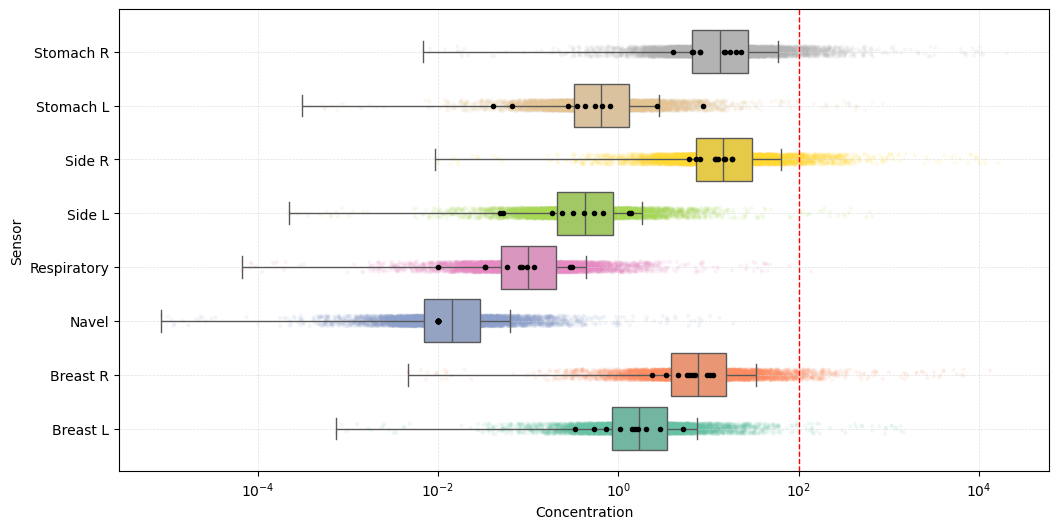

In [599]:
# Construire un DataFrame pour le boxplot
data_list = []
for i, sensor in enumerate(sensors.cat.categories):
    df_temp = pd.DataFrame({
        'Valeur': GM_sensors[i],
        'Sensor': sensor
    })
    data_list.append(df_temp)

df_z = pd.concat(data_list, ignore_index=True)

# Plot
plt.figure(figsize=(12, 6))
    
sns.boxplot(x='Valeur', y='Sensor',data=df_z,hue='Sensor',palette='Set2',showfliers=False,dodge=False,legend=False,zorder=2)
sns.stripplot(x='Valeur', y='Sensor',data=df_z,hue='Sensor',palette='Set2',alpha=0.1,size=3,dodge=False,legend=False,zorder=1)

# Points noirs observations réelles
df_obs = df[df['NDL'] == False]
sensors_groups = df_obs.groupby('Sensor')
for sensor, group in sensors_groups:
    values = group['ValueNDL'].values
    plt.plot( values, [sensor]*len(values), 'o', color='black', alpha=1, markersize=3, zorder=3)
    
# Points rouge NDL   
df_obs = df[df['NDL'] == True]
sensors_groups = df_obs.groupby('Sensor')
for sensor, group in sensors_groups:
    values = group['ValueNDL'].values
    plt.plot( values*VLE, [sensor]*len(values), 'o', color='red', alpha=1, markersize=3, zorder=3)

plt.axvline(x=VLE, color='red', linestyle='--', linewidth=1)
plt.grid(which='both', color='lightgray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xscale('log')
plt.gca().invert_yaxis()
plt.xlabel('Concentration')
plt.ylabel('Sensor')    

plt.show()

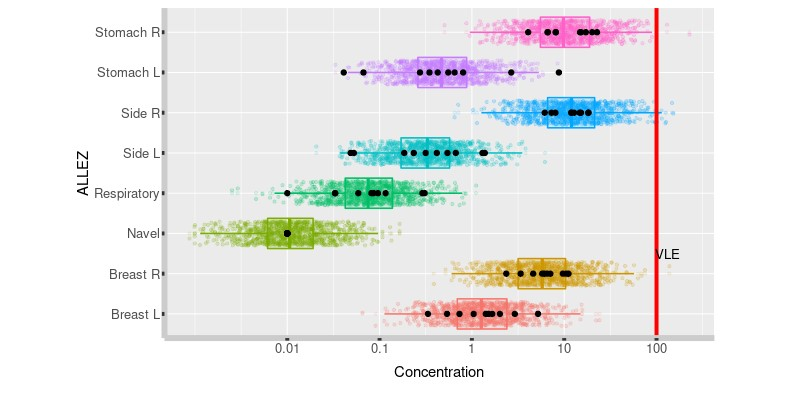
DataNDL

In [573]:
# Analyse
mu_samples = trace.posterior['mu'].values.flatten()                  
sigma_samples = trace.posterior['sigma_w'].values.flatten()  

GM_pop_samples = np.exp(mu_samples) * VLE

In [574]:
print(f"VLE:{VLE} DPAC: 65.504459220374")
print("Gestion de l'incertitude : probabilité de risque de surexposition") 
print(f"EXPO: 19%")
p_exceed_overall = trace.posterior['p_exceed_overall'].values.flatten()
print(f"p_exceed_overall: {np.mean(p_exceed_overall):.2%}") 

VLE:100 DPAC: 65.504459220374
Gestion de l'incertitude : probabilité de risque de surexposition
EXPO: 19%
p_exceed_overall: 0.95%


In [575]:
GM_pop_mean = float(GM_pop_samples.mean())
GM_pop_median = float(np.median(GM_pop_samples))
GM_pop_hdi = az.hdi(GM_pop_samples, hdi_prob=0.95)

geo_mean_ci =  np.percentile(GM_pop_samples, [2.5, 97.5])

print("Paramètres estimés") 
print(f"GM EXPO: 0.73 [0.16-3.7]")
print(f"Moyenne géométrique : {GM_pop_median:.2f}")
print(f"Intervalle crédibilité 95% : [{GM_pop_hdi[0]:.2f}, {GM_pop_hdi[1]:.2f}]")

print("")
print(f"SD EXPO: 10 [5.6 - 40]")
geo_sd_ci =  np.exp(np.percentile(sigma_samples, [2.5, 97.5]))
print(f"Estimation de l'écart-type géométrique :  {np.exp(np.mean(sigma_samples)):.2f}")
print(f"Intervalle crédibilité 95% : [{geo_sd_ci[0]:.2f}, {geo_sd_ci[1]:.2f}]")

print("")
print(f"Fraction de dépassement EXPO: 1.82 % [ 0.174 - 10.5 ]")
fd_mean = np.mean(fd_samples)
fd_hdi = az.hdi(fd_samples, hdi_prob=CIP)
print(f"Estimé : {fd_mean:.2%}")
print(f"Intervalle de crédibilité {CIP:.0%} : [{fd_hdi[0]:.2f}, {fd_hdi[1]:.2f}]")


Paramètres estimés
GM EXPO: 0.73 [0.16-3.7]
Moyenne géométrique : 0.75
Intervalle crédibilité 95% : [0.00, 4.68]

SD EXPO: 10 [5.6 - 40]
Estimation de l'écart-type géométrique :  2.46
Intervalle crédibilité 95% : [2.15, 2.90]

Fraction de dépassement EXPO: 1.82 % [ 0.174 - 10.5 ]
Estimé : 100.00%
Intervalle de crédibilité 90% : [1.00, 1.00]
